In [7]:
'''
This program calculates the time evolution of two on-site interacting particles in a driven superlattice
embedded in a harmonic oscillator.

By rescaling everything by the hopping amplitude J1, we have 4 free system parameters:
                - Hopping amplitude J2
                - Interaction amplitude U
                - Harmonic oscillator amplitude A
                - Alternating energy offset Delta
                - Driving amplitude V0
                - Driving frequency w
                
Note that if the harmonic oscillator is supposed to be located in the middle of the lattice, the amount
of lattice sites considered 'n' has to be an odd number!
'''

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
from matplotlib import colors, cm
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import scipy.linalg as linalg
from scipy.fft import fft, fftfreq
from scipy.special import jv
from scipy.optimize import curve_fit
from ipywidgets import interactive

'''
First of all, we need to set up a two particle basis in which we can explicitly represent the Hamilton
operator describing the dynamics of the system
'''

# Convert physical index to computational index
def comp(sites,x):
    return int(sites/2)+x

# Convert computational index to physical index
def phys(sites,i):
    return -int(sites/2)+i
    
# Function that normalizes a given array by L2-norm
def norm(ar):
    norm = 0
    for el in ar:
        norm += np.abs(el)**2
    return ar/np.sqrt(norm)

# Returns the 'length' of a number 
def length(number):
    length = 0
    run = 0
    while number // 10**run != 0:
        length += 1
        run += 1
    return length

# Returns the n-th digit of a number
# '1' is first position!
def numb(number,n):
    
    n+=1   # changes first position to '0'!
    if n <= length(number) and n > 0:
        tmp = number // 10**(n-1)
        res = tmp-10*(number// 10**n)
        return res
    else:
        return 'Error'

# Function that converts binary to decimal (needs functions 'length' and 'numb'!)
def dec(bi):
    l = length(bi)
    res = 0
    for i in range(0,l):
        res += numb(bi,i)*2**i
    return res

'''
# function that converts binary to decimal (does NOT depend on other functions!)
def dec(bi):
    string = str(bi)
    res = int(string,2)
    return res
'''

# Function that converts decimal to binary
def bi(dec):
    run = 0
    res = 0
    while True:
        coef = (dec-dec//(2**(run+1))*2**(run+1))/2**run
        dec -= coef*2**(run)
        if coef!=0:
            res += int(coef/coef)*10**run
        run += 1
        if dec == 0:
            break
    return res

# Function that returns the position of the 'up'-particle
# Output is of type 'comp'!
def pos_up(bi):
    run = 0
    pos = 0
    while True:
        if numb(bi,2*run+1) != 0:
            pos = run
            break
        else:
            run += 1
    return pos

# Function that returns the position of the 'down'-particle
# Output is of type 'comp'!
def pos_down(bi):
    run = 0
    pos = 0
    while True:
        if numb(bi,2*run) != 0:
            pos = run
            break
        else:
            run += 1
    return pos

# Attach binary label to 2-particle state
# Input has to be of type 'comp'!
# Counting starts at '0' from negative to positive site
def state(i,j):
    if i <= sites and j <= sites:
        return 10**(2*i+1)+10**(2*j)
    
# Function that creates ordered basis in binary representation
def basis(sites):
    
    tmp = []
    for i in range(sites): 
        for j in range(sites):
            state_dual = state(i,j)
            state_dec = dec(state_dual)
            tmp.append(state_dec)
            
    # Order basis by associated decimal value
    tmp = np.sort(np.array(tmp))
    spec = []
    for el in tmp:
        spec.append(bi(el))
    
    return np.array(spec)

# Function that gives number of basis state for given position of up and down particle
def position(sites,up,down):
    c_up = comp(sites,up)
    c_down = comp(sites,down)
    psi = state(c_up,c_down)
    spec = basis(sites)
    index = 0
    for i in range(len(spec)):
        if spec[i] == psi:
            index = i
            break
    return index

# Explicity construct Hamilton operator in given basis. Pay attention to fermionic anticommutation rules!
def Hamilton(sites,t_T,j1,j2,u,a,v0,wT,phi=0,delta=0):
    
    spec = basis(sites)
    am = len(spec)
    n = np.arange(0,am,1,dtype=int)
    
    Hamilton = np.zeros((am,am))
    
    # Construct explicit form 
    for i in range(am):
        up_i = pos_up(spec[i])
        down_i = pos_down(spec[i])
        
        for j in range(am):
            up_j = pos_up(spec[j])
            down_j = pos_down(spec[j])

            # Hopping term for up-particle        
            if np.abs(up_i-up_j) == 1 and down_i == down_j:

                # Fermionic anticommutation relations
                if (up_i < down_j and up_j >= down_j) or (up_i >= down_j and up_j < down_j):
                    p = -1
                else:
                    p = 1

                if np.abs(up_i+up_j)%4 == 1:
                    if sites%4==3:
                        Hamilton[i,j] += -j2*p
                    if sites%4==1:
                        Hamilton[i,j] += -j1*p
                    else:
                        Hamilton[i,j] += -j1*p
                        
                if np.abs(up_i+up_j)%4 == 3:
                    if sites%4==3:
                        Hamilton[i,j] += -j1*p
                    if sites%4==1:
                        Hamilton[i,j] += -j2*p
                    else:
                        Hamilton[i,j] += -j2*p

            # Hopping term for down-particle
            if np.abs(down_i-down_j) == 1 and up_i == up_j:

                # Fermionic anticommutation relations
                if (down_i <= up_j and down_j > up_j) or (down_i > up_j and down_j <= up_j):
                    p = -1
                else:
                    p = 1
                
                if np.abs(down_i+down_j)%4 == 1:
                    if sites%4==3:
                        Hamilton[i,j] += -j2*p
                    if sites%4==1:
                        Hamilton[i,j] += -j1*p
                    else:
                        Hamilton[i,j] += -j1*p
                        
                if np.abs(down_i+down_j)%4 == 3:
                    if sites%4==3:
                        Hamilton[i,j] += -j1*p
                    if sites%4==1:
                        Hamilton[i,j] += -j2*p
                    else:
                        Hamilton[i,j] += -j2*p

            if up_i == up_j and down_i == down_j:

                # Trapping term 
                Hamilton[i,j] += a*(phys(sites,up_i)**2+phys(sites,down_i)**2)

                # Interaction term
                if up_i == down_j:
                    Hamilton[i,j] += u 

                # Driving term & staggered term
                if np.abs(phys(sites,up_i))%2 == 0:
                    Hamilton[i,j] += v0/2*np.cos(wT*t_T+phi)+delta
                if np.abs(phys(sites,up_i))%2 == 1:
                    Hamilton[i,j] += -v0/2*np.cos(wT*t_T+phi)-delta                

                if np.abs(phys(sites,down_i))%2 == 0:
                    Hamilton[i,j] += v0/2*np.cos(wT*t_T+phi)+delta
                if np.abs(phys(sites,down_i))%2 == 1:
                    Hamilton[i,j] += -v0/2*np.cos(wT*t_T+phi)-delta
        
    return Hamilton

# Calculate time evolution using the unitary time evolution operator
def SEQ(sites,cycles,dt_T,j1,j2,u,a,v0,wT,phi,init_up=0,init_down=0,delta=0):
    
    t_T = np.arange(0,cycles,dt_T)
    #tU_h = np.arange(0,cycles*2*np.pi,dtU_h)
    n = len(t_T)
    hopping = np.zeros(n-1,dtype=complex)
    
    init = position(sites,init_up,init_down)
    psi = np.zeros((sites**2,n),dtype=complex)
    psi[init,0] = 1
                    
    for i in range(n-1):

        H = Hamilton(sites,t_T[i],j1,j2,u,a,v0,wT,phi,delta)
        U = linalg.expm(-1j*dt_T*H)
        psi[:,i+1] = np.matmul(U,psi[:,i])
        hopping[i] = psi[0,i]*np.conj(psi[1,i])+np.conj(psi[0,i])*psi[1,i]
        
    return t_T,psi,hopping

print('Done!')

Done!


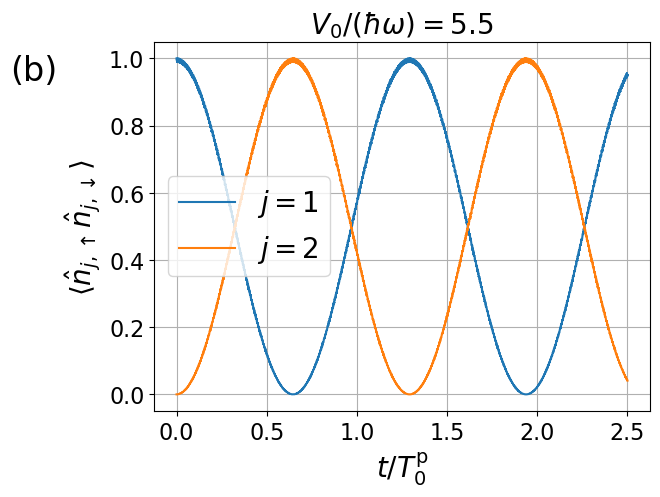

In [2]:
######################################################
# Part1: Two site oscillations of local pair density #
######################################################

critical = 2.408    # First root of zeroth Bessel function

sites = 2
U_J1= 60
J2_J1 = 0
A_J1 = 0
V0_J1 = 100
hw_J1 = 50
Delta_J1 = 0

# Parameters in units of h/T_0^p (h: Reduced Planck constant, T_0^p: Time period of two site
# oscillations of local pair density for no drive and no imbalance)
j1 = np.pi/2*U_J1
j2 = np.pi/2*J2_J1*U_J1
u = np.pi/2*U_J1**2
a = np.pi/2*A_J1*U_J1
wT = np.pi/2*hw_J1*U_J1
#v0 = np.pi/2*V0_J1*U_J1   
v0 = 5.5*wT
delta = np.pi/2*Delta_J1*U_J1

cycles= 2.5

t_T, psi, hopping = SEQ(sites=sites,cycles=cycles,j1=j1,j2=j2,dt_T=0.0001,u=u,a=a,v0=v0,wT=wT,phi=0)
n = len(t_T)

# Plotting 
fig, ax = plt.subplots()  
plt.grid(True)
plt.xlabel(r'$t/T_0^\mathrm{p}$',fontsize=20)
plt.ylabel(r'$\langle\hat{n}_{j,\uparrow}\hat{n}_{j,\downarrow}\rangle$',fontsize=20)
plt.title(r'$V_0/(\hbar\omega)=%.1f$' % (v0/wT),fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(t_T,np.abs(psi[position(sites,0,0),:])**2,label='$j=1$')#,linestyle='--')
plt.plot(t_T,np.abs(psi[position(sites,1,1),:])**2,label='$j=2$')#,linestyle='--')
plt.legend(loc='best',fontsize=20)
fig.text(-0.1,0.8,'(b)',fontsize=24)
plt.show()

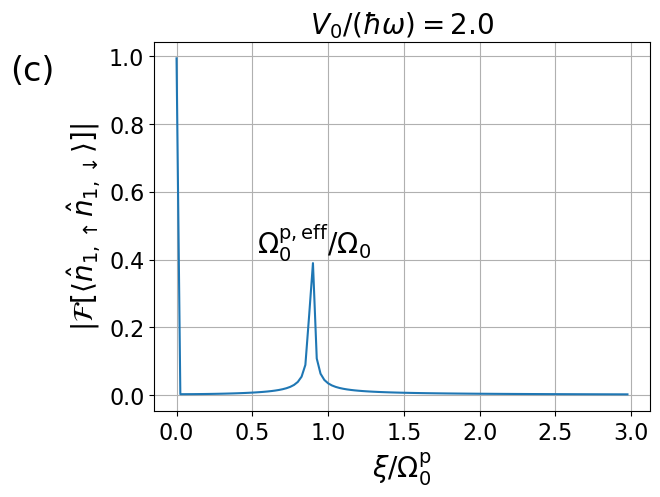

In [4]:
# this function returns angular frequencies w=2pi*f!
def fft_clean(signal):
    m = len(signal)
    freq = fftfreq(m)
    mask = freq >= 0
    amp = 2*np.abs(fft(signal/m))
    freq = m*freq[mask]
    amp = amp[mask]
    return freq, amp

critical = 2.408    # First root of zeroth Bessel function
cycles = 40

sites = 2
U_J1 = 60
J2_J1 = 0
A_J1 = 0
hw_J1 = 50
V0_J1 = 80
Delta_J1 = 0
dt_T = 0.001

# Parameters in units of h/T_0^p (h: Reduced Planck constant, T_0^p: Time period of two site
# oscillations of local pair density for no drive and no imbalance)
j1 = np.pi/2*U_J1
j2 = np.pi/2*J2_J1*U_J1
u = np.pi/2*U_J1**2
a = np.pi/2*A_J1*U_J1
wT = np.pi/2*hw_J1*U_J1
#v0 = np.pi/2*V0_J1*U_J1
v0 = 2*wT
delta = np.pi/2*Delta_J1*U_J1

t_T, psi, hopping = SEQ(sites=sites,cycles=cycles,j1=j1,j2=j2,dt_T=dt_T,u=u,a=a,v0=v0,wT=wT,phi=0,delta=delta)
density = np.abs(psi)**2
freq, amp = fft_clean(density[position(sites,0,0),:])
#amp[0] = 0

# Save data
'''
with open('ENTER FILEPATH HERE', 'w') as file:
    file.write('#The Parameters read: dt/T=%.5f, Cycles=%.3f, U/J1=%.3f, hw/J1=%.3f, V0/J1=%.3f, Delta/J1=%.3f\n' % (dt_T,cycles,U_J1,hw_J1,V0_J1,Delta_J1))
    file.write('#Omega*T0 FourierTrafo\n')
    for i in range(len(freq)):
        file.write('%s %s\n' % (freq[i]/cycles, amp[i]))     
'''

# loading data
# dataF1 = np.loadtxt('../../Data/TwoParticles/Oscillations/Fourier1.txt')
# dataF2 = np.loadtxt('../../Data/TwoParticles/Oscillations/Fourier2.txt')

# Plotting frequency spectrum
fig, ax = plt.subplots()
plt.grid()
plt.xlabel(r'$\xi/\Omega_0^\mathrm{p}$', fontsize=20)
plt.ylabel(r'$|\mathcal{F}[\langle\hat{n}_{1,\uparrow}\hat{n}_{1,\downarrow}\rangle]|$', fontsize=20)
plt.title(r'$V_0/(\hbar\omega)=%.1f$' % (v0/wT),fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(freq[0:3*cycles]/cycles,amp[0:3*cycles])
plt.text(0.53,0.42,r'$\Omega^\mathrm{p,eff}_0/\Omega_0$',fontsize=20)
fig.text(-0.1,0.8,'(c)',fontsize=24)
plt.show()

10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
100.0 %


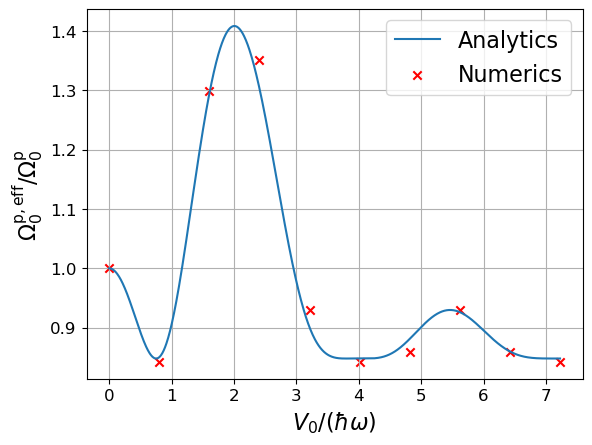

"\nplt.xlabel(r'$V_0/(\\hbar\\omega)$', fontsize=16)\nplt.ylabel(r'$\\Omega^\\mathrm{p,eff}\\left(\x0crac{V_0}{\\hbar\\omega},\x0crac{\\Delta}{J_1^\\mathrm{p}}\right)/\\Omega^\\mathrm{p,eff}\\left(0,\x0crac{\\Delta}{J_1^\\mathrm{p}}\right)$',fontsize=16)\nplt.xticks(fontsize=12)\nplt.yticks(fontsize=12)\nplt.grid()\nplt.plot(z,z,c='black',label='Analytics')\nplt.scatter(z,z,c='black',label='Numerics',marker='x')\nplt.scatter(z,z,c='r',label=r'$\\Delta=0J_1^\\mathrm{p}$',marker='o')\nplt.scatter(z,z,c='g',label=r'$\\Delta=0.4J_1^\\mathrm{p}$',marker='o')\nplt.scatter(z,z,c='b',label=r'$\\Delta=0.8J_1^\\mathrm{p}$',marker='o')\n# Delta_Jeff=0\nplt.plot(x,Frequency(x,Delta_Jeff=0)/Frequency(0,Delta_Jeff=0),c='r')\nplt.scatter(dataD0[:,0],dataD0[:,1]/dataD0[0,1],c='r',marker='x')\n# Delta_Jeff=0.4\nplt.plot(x,Frequency(x,Delta_Jeff=0.4)/Frequency(0,Delta_Jeff=0.4),c='g')\nplt.scatter(dataD04[:,0],dataD04[:,1]/dataD04[0,1],c='g',marker='x')\n# Delta_Jeff=0.8\nplt.plot(x,Frequency(x,Delta_Je

In [5]:
# Note that we agreed to use U/J1=60, hw/J1=60!
# this function returns angular frequencies w=2pi*f!
def fft_clean(signal):
    m = len(signal)
    freq = fftfreq(m)
    mask = freq >= 0
    amp = 2*np.abs(fft(signal/m))
    freq = m*freq[mask]
    amp = amp[mask]
    return freq, amp

critical = 2.408    # First root of zeroth Bessel function

sites = 2
U_J1 = 60
J2_J1 = 0
A_J1 = 0
#V0_J1 = 2*critical*wT
hw_J1 = 50 # 30
Delta_Jeff = 0.8

# Parameters in units of h/T_0^p (h: Reduced Planck constant, T_0^p: Time period of two site
# oscillations of local pair density for no drive and no imbalance)
j1 = np.pi/2*U_J1
j2 = np.pi/2*J2_J1*U_J1
u = np.pi/2*U_J1**2
a = np.pi/2*A_J1*U_J1
wT = np.pi/2*hw_J1*U_J1
delta = np.pi*Delta_Jeff

v0_end = 3*critical*wT
v0 = np.linspace(0,v0_end,10)
k = len(v0)

# Analytical Results from Floquet-Schrieffer-Wolff transformation
def Frequency(x,U_J1=U_J1,hw_J1=hw_J1,Delta_Jeff=Delta_Jeff):
    f = 0
    for n in range(100):
        f += (-1)**n*jv(n,x)**2/(U_J1/hw_J1-n)
    res = U_J1/hw_J1*np.sqrt(f**2+(2*hw_J1/U_J1*Delta_Jeff)**2)
    return res

#'''
Omega = np.zeros(k)

cycles = 30

for i in range(k):
    # The time discretisation dt_T should not be chosen bigger than 0.0001!
    t_T, psi, hopping = SEQ(sites=sites,cycles=cycles,j1=j1,j2=j2,dt_T=0.0002,u=u,a=a,v0=v0[i],wT=wT,phi=0,delta=delta)
    density = np.abs(psi)**2
    freq, amp = fft_clean(density[position(sites,0,0)])
    amp[0] = 0
    index = np.argmax(amp[0:4*cycles])
    Omega[i] = freq[index]/cycles
    #plt.plot(freq[0:4*cycles]/cycles,amp[0:4*cycles])
    #plt.show()
    print('%.1f %%' % ((i+1)/k*100))
#'''

# Printing data to .txt file
'''
with open('ENTER FILEPATH HERE', 'w') as file:
    file.write('# data for U_J1=60,hw_J1=50\n')
    file.write('# we chose cycles=30 and dt_T=0.0002\n')
    file.write('# v= / \hbar\omega Omega / T^(-1)\n')
    for i in range(len(v0)):
        file.write('%.8f %.8f\n' % (v0[i]/wT, Omega[i]))
'''

# Load data calculated earlier – if you need it, just let me know!
'''
# Delta_Jeff = 0
dataD0 = np.loadtxt('../../Data/TwoParticles/Oscillations/Oscillations_Delta00.txt')

# Delta_Jeff = 0.4
dataD04 = np.loadtxt('../../Data/TwoParticles/Oscillations/Oscillations_Delta04.txt')

# Delta_Jeff = 0.8
dataD08 = np.loadtxt('../../Data/TwoParticles/Oscillations/Oscillations_Delta08.txt')
'''

x = np.linspace(0,v0_end/wT,1000)

#'''
# Plot dependency of effective frequency of local pair density on driving parameters for given value
# of the imbalance
plt.xlabel(r'$V_0/(\hbar\omega)$', fontsize=16)
plt.ylabel(r'$\Omega^\mathrm{p,eff}_0/\Omega^\mathrm{p}_0$',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.plot(x,Frequency(x,Delta_Jeff=Delta_Jeff)/Frequency(0,Delta_Jeff=Delta_Jeff),c='#1f77b4',label=r'Analytics')
plt.scatter(v0/wT,Omega/Omega[0],c='r',marker='x',label=r'Numerics')
plt.legend(loc='upper right',fontsize=16)#,fontsize=24)
plt.show()
  
z = np.NaN

# Plot effective frequency of local pair density for several values of imbalance (needs local data)
'''
plt.xlabel(r'$V_0/(\hbar\omega)$', fontsize=16)
plt.ylabel(r'$\Omega^\mathrm{p,eff}\left(\frac{V_0}{\hbar\omega},\frac{\Delta}{J_1^\mathrm{p}}\right)/\Omega^\mathrm{p,eff}\left(0,\frac{\Delta}{J_1^\mathrm{p}}\right)$',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.plot(z,z,c='black',label='Analytics')
plt.scatter(z,z,c='black',label='Numerics',marker='x')
plt.scatter(z,z,c='r',label=r'$\Delta=0J_1^\mathrm{p}$',marker='o')
plt.scatter(z,z,c='g',label=r'$\Delta=0.4J_1^\mathrm{p}$',marker='o')
plt.scatter(z,z,c='b',label=r'$\Delta=0.8J_1^\mathrm{p}$',marker='o')
# Delta_Jeff=0
plt.plot(x,Frequency(x,Delta_Jeff=0)/Frequency(0,Delta_Jeff=0),c='r')
plt.scatter(dataD0[:,0],dataD0[:,1]/dataD0[0,1],c='r',marker='x')
# Delta_Jeff=0.4
plt.plot(x,Frequency(x,Delta_Jeff=0.4)/Frequency(0,Delta_Jeff=0.4),c='g')
plt.scatter(dataD04[:,0],dataD04[:,1]/dataD04[0,1],c='g',marker='x')
# Delta_Jeff=0.8
plt.plot(x,Frequency(x,Delta_Jeff=0.8)/Frequency(0,Delta_Jeff=0.8),c='b')
plt.scatter(dataD08[:,0],dataD08[:,1]/dataD08[0,1],c='b',marker='x')
plt.legend(loc='best',fontsize=13)
plt.show()
'''

In [9]:
# Look at time evolution of projection on all basis vectors (including i≠j)
sites = 9
U_J1 = 50
J2_J1 = 1
A_J1 = 0
V0_J1 = 0
hw_J1 = 40

# Parameters in units of h/T_0^p (h: Reduced Planck constant, T_0^p: Time period of two site
# oscillations of local pair density for no drive and no imbalance)
j1 = np.pi/2*U_J1 
j2 = np.pi/2*J2_J1*U_J1
u = np.pi/2*U_J1**2
a = np.pi/2*A_J1*U_J1
wT = np.pi/2*hw_J1*U_J1
v0 = np.pi/2*V0_J1*U_J1*2/5
v0 = critical*wT
v0 = 5/10*v0

cycles= 0.15
dt_T = 0.005

t_T, psi, hopping = SEQ(sites=sites,cycles=cycles,j1=j1,j2=j2,dt_T=dt_T,u=u,a=a,v0=v0,wT=wT,phi=0)
n = len(t_T)

density = np.abs(psi)**2
pos = np.arange(phys(sites,0),phys(sites,sites),1)

spec = basis(sites)
density_time = np.zeros((sites,sites,n))

for i in range(len(spec)):
    up_i = pos_up(spec[i])
    down_i = pos_down(spec[i])
    for j in range(n):
        density_time[up_i,down_i,j] = density[i,j]

up, down = np.meshgrid(pos,pos)

def plotting(i):
    plt.figure(figsize=(6,5))
    plt.pcolormesh(up,down,density_time[:,:,i],cmap='Blues_r',shading='auto',norm=Normalize(vmin=1e-10,vmax=1))
    plt.colorbar()
    plt.xlabel(r'$i$',fontsize=24)
    plt.ylabel(r'$j$',fontsize=24)
    plt.title(r'$\langle\hat{n}_{i,\downarrow}\hat{n}_{j,\uparrow}\rangle(t=%.4f T_0^\mathrm{p})$' % (i*dt_T),fontsize=32)
    
interactive_plot = interactive(plotting,i=(0,n-1,1))
interactive_plot 

interactive(children=(IntSlider(value=14, description='i', max=29), Output()), _dom_classes=('widget-interact'…

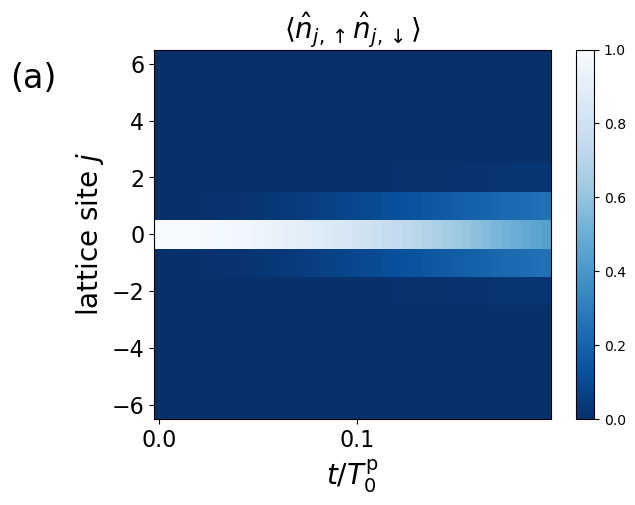

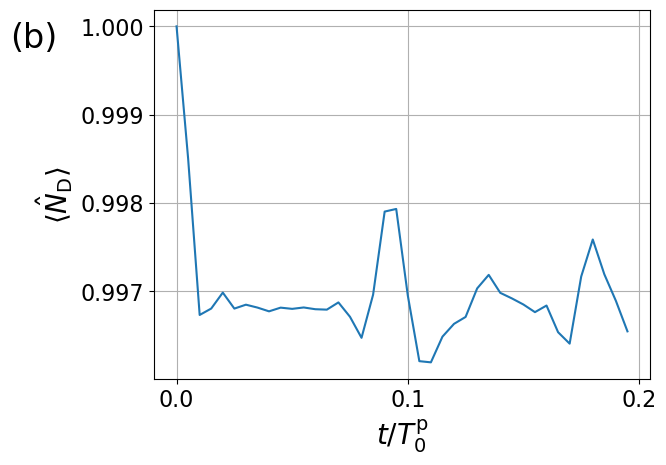

The highest probability to find the two particles on different sites is given by 0.38%


In [10]:
##################################################
# Part2: Particle pair propagation in 1D-lattice #
##################################################
sites = 13
U_J1 = 50
J2_J1 = 1
A_J1 = 0
V0_J1 = 0
hw_J1 = 40

# Parameters in units of h/T_0^p (h: Reduced Planck constant, T_0^p: Time period of two site
# oscillations of local pair density for no drive and no imbalance)
j1 = np.pi/2*U_J1 
j2 = np.pi/2*J2_J1*U_J1
u = np.pi/2*U_J1**2
a = np.pi/2*A_J1*U_J1
wT = np.pi/2*hw_J1*U_J1
v0 = 0*2*wT*0

cycles= 0.2

#'''
t_T, psi, hopping = SEQ(sites=sites,cycles=cycles,j1=j1,j2=j2,dt_T=0.005,u=u,a=a,v0=v0,wT=wT,phi=0)
n = len(t_T)
       
density = np.abs(psi)**2
pos = np.arange(phys(sites,0),phys(sites,sites),1)

spec = basis(sites)
density_heat = np.zeros((sites,n))

for i in range(len(spec)):
    up_i = pos_up(spec[i])
    down_i = pos_down(spec[i])
    if up_i == down_i:
        for j in range(n):
            density_heat[up_i,j] = density[i,j]

heat_t_T,heat_pos = np.meshgrid(t_T,pos)
#'''

# Plotting time evolution heat-plot
fig = plt.figure()
plt.title(r'$\langle\hat{n}_{j,\uparrow}\hat{n}_{j,\downarrow}\rangle$',fontsize=20)
plt.xlabel(r'$t/T_0^\mathrm{p}$',fontsize=20)
plt.ylabel(r'lattice site $j$',fontsize=20)
plt.xticks(np.arange(0,cycles+0.1,0.1),fontsize=16)
plt.yticks(fontsize=16)
plt.pcolormesh(heat_t_T,heat_pos,density_heat,cmap='Blues_r',shading='auto')#,norm=LogNorm(vmin=1e-9,vmax=1))
plt.colorbar()
fig.text(-0.1,0.8,'(a)',fontsize=24)
plt.show()

# Projection on subspace where the two particles are located on the same site
Projection = np.zeros(n)
for i in range(n):
    for j in range(sites):
        Projection[i] += density_heat[j,i]

#plt.figure(figsize=(12,10))
fig = plt.figure()
plt.grid()
plt.xlabel(r'$t/T_0^\mathrm{p}$',fontsize=20)
plt.ylabel(r'$\langle\hat{N}_\mathrm{D}\rangle$',fontsize=20)
plt.xticks(np.arange(0,cycles+0.1,0.1),fontsize=16)
plt.yticks(np.arange(0.9960,1+0.001,0.001),fontsize=16)
plt.plot(t_T,Projection)
fig.text(-0.1,0.8,'(b)',fontsize=24)
plt.show(True)

# Highest probability to find the two particles on different sites
print('The highest probability to find the two particles on different sites is given by %.2f%%' % ((1-np.min(Projection))*100))


In [11]:
# Time evolution of spatial standard deviation

def lin_func(x,m,b):
    return m*x+b

# Calculates first moment
def mom1(ar):
    m = len(ar)
    m1 = 0
    for i in range(m):
        m1 += ar[i]*phys(sites,i)
    return m1
   
# Calculates second moment
def mom2(ar):
    m = len(ar)
    m2 = 0
    for i in range(m):
        m2 += ar[i]*phys(sites,i)**2
    return m2

# Calculates standard deviation
def sigma(ar):
    mom_1 = mom1(ar)
    mom_2 = mom2(ar)
    deviation = mom_2-mom_1**2
    return deviation

dt_T = 0.0002
cycles = 0.16

sites = 5
U_J1 = 50
J2_J1 = 1
A_J1 = 0
V0_J1 = 0
hw_J1 = 40

# Parameters in units of h/T_0^p (h: Reduced Planck constant, T_0^p: Time period of two site
# oscillations of local pair density for no drive and no imbalance)
j1 = np.pi/2*U_J1
j2 = np.pi/2*J2_J1*U_J1
u = np.pi/2*U_J1**2
a = np.pi/2*A_J1*U_J1
wT = np.pi/2*hw_J1*U_J1

# Resolve Bessel like dependency of effective hopping amplitude by calculating (linear) time evolution of
# spatial standard deviation for several values of driving parameters. By fitting a linear function, we can 
# (up to a constant scaling factor) extract the value of the effective hopping amplitude.
def Bessel(delta,j1=j1,j2=j2,u=u,a=a,wT=wT,cycles=cycles,dt_T=dt_T):

    v0 = np.linspace(0,7.2*wT,10)

    k = len(v0)
    params = np.zeros((k,2))
    results = np.zeros((k,int(cycles/dt_T)))
    est = np.array([0,0])

    for i in range(k):
        ret = SEQ(sites,cycles,dt_T,j1,j2,u=u,a=a,v0=v0[i],wT=wT,phi=0,delta=delta)
        t_T, psi, hopping = ret
        density = np.abs(psi)**2
        m = len(t_T)           
        
        spec = basis(sites)
        density_heat = np.zeros((sites,m))

        for j in range(len(spec)):
            up_j = pos_up(spec[j])
            down_j = pos_down(spec[j])
            if up_j == down_j:
                for l in range(m):
                    density_heat[up_j,l] = density[j,l]

        deviation = np.zeros(m)

        for j in range(m):
            deviation[j] = np.sqrt(sigma(density_heat[:,j]))

        popt, pcov = curve_fit(lin_func,t_T,deviation,est)
        
        results[i,:] = deviation
        params[i,:] = popt
        print('%.2f%%' % ((i+1)/k*100))

    return t_T, v0/wT, results, params

print('Done!')

Done!


In [12]:
# keep in mind that a appropriate step size dt_T is crucial! We only get reasonable results for
# dt_T <= 0.0002!

Delta1_J1 = 0
delta1 = np.pi/2*Delta1_J1*U_J1
t_T, v0, results1, params1 = Bessel(delta1)

# Store data
'''
with open('ENTER FILEPATH HERE', 'w') as file:
    file.write('#sites=%i, dt/T=%s, cycles=%s, U/J1=%.3f, hw/J1=%.3f\n' % (sites, dt_T, cycles, U_J1, hw_J1))
    file.write('#V0/hw J^(p,eff)/J^p\n')
    for i in range(len(v0)):
        file.write('%s %s\n' % (v0[i], params1[i,0]/params1[0,0]))
'''

10.00%
20.00%
30.00%
40.00%
50.00%
60.00%
70.00%
80.00%
90.00%
100.00%


"\nwith open('ENTER FILEPATH HERE', 'w') as file:\n    file.write('#sites=%i, dt/T=%s, cycles=%s, U/J1=%.3f, hw/J1=%.3f\n' % (sites, dt_T, cycles, U_J1, hw_J1))\n    file.write('#V0/hw J^(p,eff)/J^p\n')\n    for i in range(len(v0)):\n        file.write('%s %s\n' % (v0[i], params1[i,0]/params1[0,0]))\n"

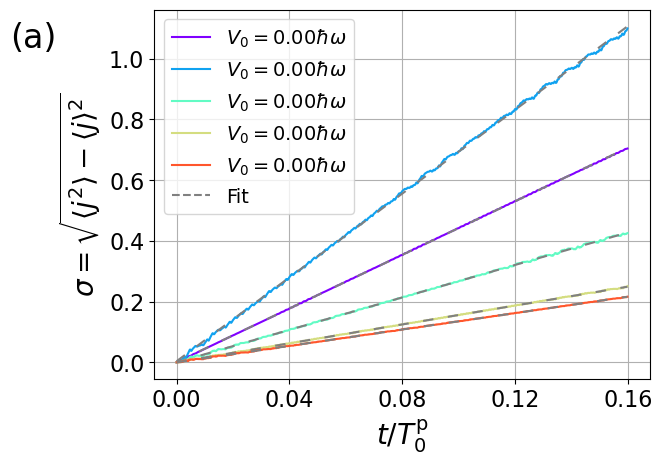

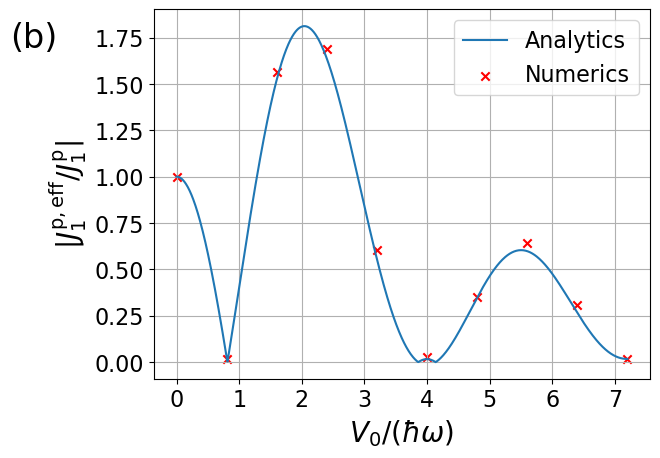

In [13]:
# Load local data – if you need the data, just let me know!
#data = np.loadtxt('../../Data/TwoParticles/Propagation/Delocalisation.txt')

k = len(params1[:,0])
colors = cm.rainbow(np.linspace(0,1,k))

# Plotting linear time evolution of standard deviation with line fits
fig = plt.figure(9)
plt.grid()
plt.xlabel(r'$t/T_0^\mathrm{p}$',fontsize=20)
plt.ylabel(r'$\sigma=\sqrt{\langle j^2 \rangle - \langle j \rangle^2}$',fontsize=20)
plt.xticks(np.array([0.00,0.04,0.08,0.12,0.16]),fontsize=16)
plt.yticks(fontsize=16)

for i in range(0,k,2):    
    plt.plot(t_T,results1[i,:],label=r'$V_0=%.2f\hbar\omega$' % (v0[i]/wT),c=colors[i])
    plt.plot(t_T,lin_func(t_T,*params1[i,:]),linestyle=(0,(5,7)),color='grey',alpha=1)

plt.plot(np.NaN,np.NaN,c='grey',label='Fit',linestyle='--')
plt.legend(loc='best',fontsize=14)
fig.text(-0.1,0.8,'(a)',fontsize=24)
plt.show()

x = np.linspace(0,v0[-1],1000)

# Plotting dependency of effective pair hopping amplitude on the driving parameters
fig = plt.figure()
plt.grid()
plt.xlabel(r'$V_0/(\hbar\omega)$', fontsize=20)
plt.ylabel(r'$|J^\mathrm{p,eff}_1/J_1^\mathrm{p}|$',fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(x,np.abs(Frequency(x,U_J1,hw_J1,Delta_Jeff=0)),label='Analytics')
plt.scatter(v0,params1[:,0]/params1[0,0],marker='x',c='r',label='Numerics')
plt.legend(loc='best',fontsize=16)
fig.text(-0.1,0.8,'(b)',fontsize=24)
plt.show()
